In [1]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.optim as  optim 
from torchvision import datasets
from torch.utils.data import DataLoader

from torch.autograd import Variable

In [2]:
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

In [3]:
if not os.path.exists('outputs'):
    os.makedirs('outputs')

In [4]:
# Discriminator network
class Discriminator(nn.Module):
    def __init__(self, in_dim=3, dim=64):
        super(Discriminator, self).__init__()

        def conv_ln_lrelu(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 5, 2, 2),
                # Since there is no effective implementation of LayerNorm,
                # we use InstanceNorm2d instead of LayerNorm here.
                nn.InstanceNorm2d(out_dim, affine=True),
                nn.LeakyReLU(0.2))

        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, dim, 5, 2, 2), nn.LeakyReLU(0.2),
            conv_ln_lrelu(dim, dim * 2),
            conv_ln_lrelu(dim * 2, dim * 4),
            conv_ln_lrelu(dim * 4, dim * 8),
            nn.Conv2d(dim * 8, 1, 4))

    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y

In [5]:
class Generator(nn.Module):

    def __init__(self, in_dim=128, dim=64):
        super(Generator, self).__init__()

        def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, 5, 2,
                                   padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU())

        self.l1 = nn.Sequential(
            nn.Linear(in_dim, dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(dim * 8 * 4 * 4),
            nn.ReLU())
        self.l2_5 = nn.Sequential(
            dconv_bn_relu(dim * 8, dim * 4),
            dconv_bn_relu(dim * 4, dim * 2),
            dconv_bn_relu(dim * 2, dim),
            nn.ConvTranspose2d(dim, 3, 5, 2, padding=2, output_padding=1),
            nn.Tanh())

    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y

In [6]:
def show(img,renorm=False,nrow=8,interpolation='bicubic'):
  if renorm:
    img = img/2 + 0.5
  img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
  plt.figure()
  plt.imshow(np.transpose(img_grid, (1,2,0)), interpolation=interpolation)
  plt.axis('off')
  plt.show()

In [7]:

root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [8]:


crop_size = 108
re_size = 64
offset_height = (218 - crop_size) // 2
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(crop),
     transforms.ToPILImage(),
     transforms.Resize(size=(re_size, re_size), interpolation=Image.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)])

batch_size = 64
celeba_data = datasets.ImageFolder('./data_faces', transform=transform)
celeba_loader = DataLoader(celeba_data,batch_size=batch_size,shuffle=True)

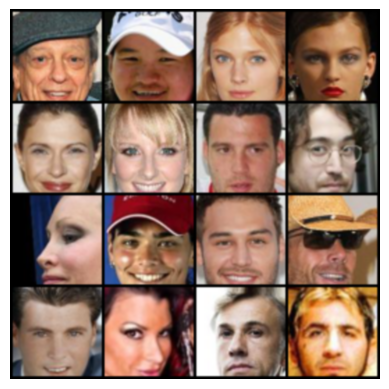

In [9]:
batch, _ = next(iter(celeba_loader))
show(batch[0:16],renorm=True, nrow=4)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# Function to initialize the model weights
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)    # mean = 0, variance = 0.02
        if isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        if isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight.data, 0.0,0.02)

In [12]:
# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)
initialize_weights(generator)
initialize_weights(discriminator)
# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [13]:
# Train the VAE
num_epochs = 50
latent_dim=128
# Lists to store losses
G_losses = []
D_losses = []
lambda_gp = 10
n_critic = 5
num_steps = 0
# Training loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(celeba_loader):
        
        real_images = real_images.to(device)
        batch_size=real_images.size(0)
        # Train discriminator
        for _ in range(n_critic):
            
            # Train discriminator
            optimizer_D.zero_grad()

            # Discriminator output for real images
            D_real = discriminator(real_images)
            D_real_loss = torch.mean(D_real)

            # Generate fake images and compute discriminator output
            z = torch.randn(batch_size, latent_dim).cuda()
            fake_images = generator(z)
            D_fake = discriminator(fake_images.detach())
            D_fake_loss = torch.mean(D_fake)

            # Compute gradient penalty
            alpha = torch.rand(batch_size, 1, 1, 1).cuda()
            x_hat = alpha * real_images.data + (1 - alpha) * fake_images.data
            x_hat.requires_grad = True
            pred_hat = discriminator(x_hat)
            gradients = torch.autograd.grad(outputs=pred_hat, inputs=x_hat,
                                                grad_outputs=torch.ones(pred_hat.size()).cuda(),
                                                create_graph=True, retain_graph=True, only_inputs=True)[0]
            gradient_penalty = lambda_gp * torch.mean((1. - torch.sqrt(1e-8+torch.sum(gradients.view(gradients.size(0), -1)**2, dim=1)))**2)# torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12).mean() 

            # Compute total discriminator loss
            D_loss = D_fake_loss - D_real_loss + gradient_penalty
            D_loss.backward()
            optimizer_D.step()

            
        # Train generator
        optimizer_G.zero_grad()

        # Generate fake images and compute discriminator output
        z = torch.randn(batch_size, latent_dim).cuda()
        fake_images = generator(z)
        D_fake = discriminator(fake_images)
        G_loss = -torch.mean(D_fake)

        G_loss.backward()
        optimizer_G.step()
        
        # Append losses to lists
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())
        # Print progress
        if i % 100 == 0:
            print(
                f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(celeba_loader)}] "
                f"[D loss: {D_loss.item()}] [G loss: {G_loss.item()}]"
            )
            with torch.no_grad():
                
                fake_images = fake_images.detach().cpu().permute(0,2,3,1)/2
                fake_images += 0.5
                fake_images=fake_images.clip(0,1).numpy()
                fig, axs = plt.subplots(5, 5)
                cnt = 0
                for i in range(5):
                    for j in range(5):
                        axs[i, j].imshow(fake_images [cnt])
                        axs[i, j].axis('off')
                        cnt += 1
                plt.savefig(os.path.join("outputs",f"gan_images_epoch_{epoch}.png"))
                plt.close()

    torch.save(generator.state_dict(), os.path.join('checkpoints',f"G_{epoch}.png"))
    torch.save(discriminator.state_dict(), os.path.join('checkpoints',f"D_{epoch}.png"))



[Epoch 0/50] [Batch 0/3166] [D loss: 89.94160461425781] [G loss: 1.2226788997650146]
[Epoch 0/50] [Batch 100/3166] [D loss: -84.92124938964844] [G loss: 72.23196411132812]
[Epoch 0/50] [Batch 200/3166] [D loss: -36.27890396118164] [G loss: 63.415775299072266]
[Epoch 0/50] [Batch 300/3166] [D loss: -30.421432495117188] [G loss: 48.93073654174805]
[Epoch 0/50] [Batch 400/3166] [D loss: -19.192453384399414] [G loss: 42.628074645996094]
[Epoch 0/50] [Batch 500/3166] [D loss: -19.611000061035156] [G loss: 43.106143951416016]
[Epoch 0/50] [Batch 600/3166] [D loss: -17.052108764648438] [G loss: 40.27702331542969]
[Epoch 0/50] [Batch 700/3166] [D loss: -18.814722061157227] [G loss: 46.580379486083984]
[Epoch 0/50] [Batch 800/3166] [D loss: -15.334396362304688] [G loss: 40.102745056152344]
[Epoch 0/50] [Batch 900/3166] [D loss: -15.376520156860352] [G loss: 46.084434509277344]
[Epoch 0/50] [Batch 1000/3166] [D loss: -14.921640396118164] [G loss: 47.44331359863281]
[Epoch 0/50] [Batch 1100/3166]

[Epoch 2/50] [Batch 2900/3166] [D loss: -8.431190490722656] [G loss: 75.45137023925781]
[Epoch 2/50] [Batch 3000/3166] [D loss: -7.9274821281433105] [G loss: 81.85391235351562]
[Epoch 2/50] [Batch 3100/3166] [D loss: -6.980813980102539] [G loss: 79.62474060058594]
[Epoch 3/50] [Batch 0/3166] [D loss: -7.644926071166992] [G loss: 86.77726745605469]
[Epoch 3/50] [Batch 100/3166] [D loss: -9.345512390136719] [G loss: 73.00877380371094]
[Epoch 3/50] [Batch 200/3166] [D loss: -10.08189868927002] [G loss: 76.40642547607422]
[Epoch 3/50] [Batch 300/3166] [D loss: -7.75323486328125] [G loss: 71.48368835449219]
[Epoch 3/50] [Batch 400/3166] [D loss: -6.804152488708496] [G loss: 84.4881820678711]
[Epoch 3/50] [Batch 500/3166] [D loss: -7.607032775878906] [G loss: 80.39405822753906]
[Epoch 3/50] [Batch 600/3166] [D loss: -8.753687858581543] [G loss: 83.70213317871094]
[Epoch 3/50] [Batch 700/3166] [D loss: -5.1285481452941895] [G loss: 81.45079803466797]
[Epoch 3/50] [Batch 800/3166] [D loss: -4.

[Epoch 5/50] [Batch 2700/3166] [D loss: -6.790090084075928] [G loss: 88.0679931640625]
[Epoch 5/50] [Batch 2800/3166] [D loss: -5.107357501983643] [G loss: 91.3553237915039]
[Epoch 5/50] [Batch 2900/3166] [D loss: -3.3866851329803467] [G loss: 92.0093765258789]
[Epoch 5/50] [Batch 3000/3166] [D loss: -4.865134239196777] [G loss: 92.11756134033203]
[Epoch 5/50] [Batch 3100/3166] [D loss: -7.121662139892578] [G loss: 89.072998046875]
[Epoch 6/50] [Batch 0/3166] [D loss: -7.315674304962158] [G loss: 77.09918212890625]
[Epoch 6/50] [Batch 100/3166] [D loss: -5.094991683959961] [G loss: 88.94064331054688]
[Epoch 6/50] [Batch 200/3166] [D loss: -7.198822975158691] [G loss: 88.424560546875]
[Epoch 6/50] [Batch 300/3166] [D loss: -8.262377738952637] [G loss: 94.14324951171875]
[Epoch 6/50] [Batch 400/3166] [D loss: -6.226082801818848] [G loss: 86.03704071044922]
[Epoch 6/50] [Batch 500/3166] [D loss: -5.512639045715332] [G loss: 90.02095031738281]
[Epoch 6/50] [Batch 600/3166] [D loss: -4.2508

[Epoch 8/50] [Batch 2500/3166] [D loss: -5.972792148590088] [G loss: 98.29947662353516]
[Epoch 8/50] [Batch 2600/3166] [D loss: -6.35691499710083] [G loss: 100.37774658203125]
[Epoch 8/50] [Batch 2700/3166] [D loss: -5.099698066711426] [G loss: 103.6061019897461]
[Epoch 8/50] [Batch 2800/3166] [D loss: -6.472542762756348] [G loss: 96.92352294921875]
[Epoch 8/50] [Batch 2900/3166] [D loss: -5.927576541900635] [G loss: 98.14590454101562]
[Epoch 8/50] [Batch 3000/3166] [D loss: -4.212591648101807] [G loss: 102.45331573486328]
[Epoch 8/50] [Batch 3100/3166] [D loss: -3.9561076164245605] [G loss: 88.74830627441406]
[Epoch 9/50] [Batch 0/3166] [D loss: -5.438808917999268] [G loss: 99.85084533691406]
[Epoch 9/50] [Batch 100/3166] [D loss: -8.160541534423828] [G loss: 104.96574401855469]
[Epoch 9/50] [Batch 200/3166] [D loss: -7.523458957672119] [G loss: 90.03939819335938]
[Epoch 9/50] [Batch 300/3166] [D loss: -5.345991134643555] [G loss: 89.30892181396484]
[Epoch 9/50] [Batch 400/3166] [D lo

[Epoch 11/50] [Batch 2200/3166] [D loss: -4.454134941101074] [G loss: 99.0466537475586]
[Epoch 11/50] [Batch 2300/3166] [D loss: -4.012322425842285] [G loss: 98.82469177246094]
[Epoch 11/50] [Batch 2400/3166] [D loss: -3.9466402530670166] [G loss: 104.49064636230469]
[Epoch 11/50] [Batch 2500/3166] [D loss: -6.353600025177002] [G loss: 97.4077377319336]
[Epoch 11/50] [Batch 2600/3166] [D loss: -5.254981994628906] [G loss: 104.66436767578125]
[Epoch 11/50] [Batch 2700/3166] [D loss: -4.052793502807617] [G loss: 99.35751342773438]
[Epoch 11/50] [Batch 2800/3166] [D loss: -6.411865234375] [G loss: 92.4093017578125]
[Epoch 11/50] [Batch 2900/3166] [D loss: -4.8799004554748535] [G loss: 102.42741394042969]
[Epoch 11/50] [Batch 3000/3166] [D loss: -4.631008148193359] [G loss: 110.91948699951172]
[Epoch 11/50] [Batch 3100/3166] [D loss: -7.351912498474121] [G loss: 102.64619445800781]
[Epoch 12/50] [Batch 0/3166] [D loss: -5.584121227264404] [G loss: 106.32066345214844]
[Epoch 12/50] [Batch 1

[Epoch 14/50] [Batch 1800/3166] [D loss: -3.079662561416626] [G loss: 101.3584976196289]
[Epoch 14/50] [Batch 1900/3166] [D loss: -4.193608283996582] [G loss: 104.72879028320312]
[Epoch 14/50] [Batch 2000/3166] [D loss: -5.399500370025635] [G loss: 105.31784057617188]
[Epoch 14/50] [Batch 2100/3166] [D loss: -2.9644060134887695] [G loss: 104.19796752929688]
[Epoch 14/50] [Batch 2200/3166] [D loss: -2.701009750366211] [G loss: 106.96324157714844]
[Epoch 14/50] [Batch 2300/3166] [D loss: -4.345492362976074] [G loss: 103.11053466796875]
[Epoch 14/50] [Batch 2400/3166] [D loss: -4.117543697357178] [G loss: 101.54178619384766]
[Epoch 14/50] [Batch 2500/3166] [D loss: -3.7215213775634766] [G loss: 107.54681396484375]
[Epoch 14/50] [Batch 2600/3166] [D loss: -3.896038293838501] [G loss: 104.15687561035156]
[Epoch 14/50] [Batch 2700/3166] [D loss: -4.451560974121094] [G loss: 104.93295288085938]
[Epoch 14/50] [Batch 2800/3166] [D loss: -3.087918996810913] [G loss: 113.58195495605469]
[Epoch 14

[Epoch 17/50] [Batch 1400/3166] [D loss: -5.714937210083008] [G loss: 114.329345703125]
[Epoch 17/50] [Batch 1500/3166] [D loss: -3.5609304904937744] [G loss: 111.856689453125]
[Epoch 17/50] [Batch 1600/3166] [D loss: -4.224758148193359] [G loss: 112.05891418457031]
[Epoch 17/50] [Batch 1700/3166] [D loss: -3.6320714950561523] [G loss: 106.01555633544922]
[Epoch 17/50] [Batch 1800/3166] [D loss: -4.293260097503662] [G loss: 108.76397705078125]
[Epoch 17/50] [Batch 1900/3166] [D loss: -4.341237545013428] [G loss: 109.21759033203125]
[Epoch 17/50] [Batch 2000/3166] [D loss: -2.1059906482696533] [G loss: 116.03656005859375]
[Epoch 17/50] [Batch 2100/3166] [D loss: -5.475482940673828] [G loss: 120.58074951171875]
[Epoch 17/50] [Batch 2200/3166] [D loss: -5.757100582122803] [G loss: 101.66261291503906]
[Epoch 17/50] [Batch 2300/3166] [D loss: -4.444933891296387] [G loss: 117.51763916015625]
[Epoch 17/50] [Batch 2400/3166] [D loss: -6.44180154800415] [G loss: 110.94758605957031]
[Epoch 17/50

[Epoch 20/50] [Batch 1000/3166] [D loss: -4.68670129776001] [G loss: 118.61468505859375]
[Epoch 20/50] [Batch 1100/3166] [D loss: -3.5400032997131348] [G loss: 113.39067077636719]
[Epoch 20/50] [Batch 1200/3166] [D loss: -4.134009838104248] [G loss: 117.31092834472656]
[Epoch 20/50] [Batch 1300/3166] [D loss: -6.024772644042969] [G loss: 111.65394592285156]
[Epoch 20/50] [Batch 1400/3166] [D loss: -4.5958404541015625] [G loss: 115.53254699707031]
[Epoch 20/50] [Batch 1500/3166] [D loss: -5.376991271972656] [G loss: 116.24429321289062]
[Epoch 20/50] [Batch 1600/3166] [D loss: -2.431400775909424] [G loss: 119.27124786376953]
[Epoch 20/50] [Batch 1700/3166] [D loss: -3.4481394290924072] [G loss: 117.51290893554688]
[Epoch 20/50] [Batch 1800/3166] [D loss: -4.176324367523193] [G loss: 119.97502136230469]
[Epoch 20/50] [Batch 1900/3166] [D loss: -4.885412693023682] [G loss: 115.86055755615234]
[Epoch 20/50] [Batch 2000/3166] [D loss: -4.031790733337402] [G loss: 118.18846130371094]
[Epoch 2

[Epoch 23/50] [Batch 600/3166] [D loss: -3.9093706607818604] [G loss: 124.12515258789062]
[Epoch 23/50] [Batch 700/3166] [D loss: -4.0915327072143555] [G loss: 119.20475769042969]
[Epoch 23/50] [Batch 800/3166] [D loss: -6.260009288787842] [G loss: 127.49159240722656]
[Epoch 23/50] [Batch 900/3166] [D loss: -5.7593560218811035] [G loss: 121.4550552368164]
[Epoch 23/50] [Batch 1000/3166] [D loss: -4.129249572753906] [G loss: 122.73624420166016]
[Epoch 23/50] [Batch 1100/3166] [D loss: -4.864022254943848] [G loss: 129.759033203125]
[Epoch 23/50] [Batch 1200/3166] [D loss: -5.486869812011719] [G loss: 128.20993041992188]
[Epoch 23/50] [Batch 1300/3166] [D loss: -2.05427622795105] [G loss: 124.68524169921875]
[Epoch 23/50] [Batch 1400/3166] [D loss: -3.052292585372925] [G loss: 121.94188690185547]
[Epoch 23/50] [Batch 1500/3166] [D loss: -2.9451706409454346] [G loss: 129.586181640625]
[Epoch 23/50] [Batch 1600/3166] [D loss: -1.7628839015960693] [G loss: 127.33721160888672]
[Epoch 23/50] [

[Epoch 26/50] [Batch 200/3166] [D loss: -2.0835888385772705] [G loss: 129.0955810546875]
[Epoch 26/50] [Batch 300/3166] [D loss: -2.685136556625366] [G loss: 131.2015380859375]
[Epoch 26/50] [Batch 400/3166] [D loss: -6.190185546875] [G loss: 124.5069580078125]
[Epoch 26/50] [Batch 500/3166] [D loss: -3.7999558448791504] [G loss: 127.40800476074219]
[Epoch 26/50] [Batch 600/3166] [D loss: -3.709566593170166] [G loss: 128.79185485839844]
[Epoch 26/50] [Batch 700/3166] [D loss: -4.492232799530029] [G loss: 138.50445556640625]
[Epoch 26/50] [Batch 800/3166] [D loss: -3.1409668922424316] [G loss: 130.5220184326172]
[Epoch 26/50] [Batch 900/3166] [D loss: -4.381054401397705] [G loss: 125.88838195800781]
[Epoch 26/50] [Batch 1000/3166] [D loss: -3.8969712257385254] [G loss: 126.95162963867188]
[Epoch 26/50] [Batch 1100/3166] [D loss: -7.480775356292725] [G loss: 123.24725341796875]
[Epoch 26/50] [Batch 1200/3166] [D loss: -3.1732466220855713] [G loss: 131.84954833984375]
[Epoch 26/50] [Batch

[Epoch 28/50] [Batch 3000/3166] [D loss: -4.981224060058594] [G loss: 137.70425415039062]
[Epoch 28/50] [Batch 3100/3166] [D loss: -3.8108086585998535] [G loss: 135.33306884765625]
[Epoch 29/50] [Batch 0/3166] [D loss: -2.810319423675537] [G loss: 137.54971313476562]
[Epoch 29/50] [Batch 100/3166] [D loss: -5.501744270324707] [G loss: 145.27694702148438]
[Epoch 29/50] [Batch 200/3166] [D loss: -1.0306954383850098] [G loss: 137.53036499023438]
[Epoch 29/50] [Batch 300/3166] [D loss: -4.7854790687561035] [G loss: 133.90087890625]
[Epoch 29/50] [Batch 400/3166] [D loss: -4.094848155975342] [G loss: 139.8240966796875]
[Epoch 29/50] [Batch 500/3166] [D loss: -3.141849994659424] [G loss: 134.67813110351562]
[Epoch 29/50] [Batch 600/3166] [D loss: -4.8591508865356445] [G loss: 135.68492126464844]
[Epoch 29/50] [Batch 700/3166] [D loss: -3.739830493927002] [G loss: 132.80783081054688]
[Epoch 29/50] [Batch 800/3166] [D loss: -4.127458572387695] [G loss: 137.505126953125]
[Epoch 29/50] [Batch 90

[Epoch 31/50] [Batch 2600/3166] [D loss: -3.2600252628326416] [G loss: 141.83486938476562]
[Epoch 31/50] [Batch 2700/3166] [D loss: -4.652605056762695] [G loss: 145.14541625976562]
[Epoch 31/50] [Batch 2800/3166] [D loss: -2.8617074489593506] [G loss: 146.26058959960938]
[Epoch 31/50] [Batch 2900/3166] [D loss: -4.367845058441162] [G loss: 144.8544464111328]
[Epoch 31/50] [Batch 3000/3166] [D loss: -3.4153354167938232] [G loss: 145.8299560546875]
[Epoch 31/50] [Batch 3100/3166] [D loss: -3.784370183944702] [G loss: 138.29176330566406]
[Epoch 32/50] [Batch 0/3166] [D loss: -3.594219923019409] [G loss: 146.80007934570312]
[Epoch 32/50] [Batch 100/3166] [D loss: -2.284161329269409] [G loss: 145.16452026367188]
[Epoch 32/50] [Batch 200/3166] [D loss: -3.6324965953826904] [G loss: 142.7882537841797]
[Epoch 32/50] [Batch 300/3166] [D loss: -1.630126953125] [G loss: 141.59585571289062]
[Epoch 32/50] [Batch 400/3166] [D loss: -3.136823892593384] [G loss: 140.8934326171875]
[Epoch 32/50] [Batch

[Epoch 34/50] [Batch 2200/3166] [D loss: -4.904891490936279] [G loss: 160.079345703125]
[Epoch 34/50] [Batch 2300/3166] [D loss: -3.040269613265991] [G loss: 155.2493133544922]
[Epoch 34/50] [Batch 2400/3166] [D loss: -3.71213960647583] [G loss: 148.90420532226562]
[Epoch 34/50] [Batch 2500/3166] [D loss: -3.612180233001709] [G loss: 153.30001831054688]
[Epoch 34/50] [Batch 2600/3166] [D loss: -2.234337329864502] [G loss: 156.24468994140625]
[Epoch 34/50] [Batch 2700/3166] [D loss: -2.8590450286865234] [G loss: 158.74545288085938]
[Epoch 34/50] [Batch 2800/3166] [D loss: -3.7684054374694824] [G loss: 153.78125]
[Epoch 34/50] [Batch 2900/3166] [D loss: -2.6844305992126465] [G loss: 157.45046997070312]
[Epoch 34/50] [Batch 3000/3166] [D loss: -3.7261500358581543] [G loss: 160.122314453125]
[Epoch 34/50] [Batch 3100/3166] [D loss: -3.1032042503356934] [G loss: 157.4930419921875]
[Epoch 35/50] [Batch 0/3166] [D loss: -4.072078227996826] [G loss: 154.80398559570312]
[Epoch 35/50] [Batch 100

[Epoch 37/50] [Batch 1800/3166] [D loss: -4.150739669799805] [G loss: 174.15147399902344]
[Epoch 37/50] [Batch 1900/3166] [D loss: -4.524819374084473] [G loss: 170.37261962890625]
[Epoch 37/50] [Batch 2000/3166] [D loss: -4.442482948303223] [G loss: 165.70516967773438]
[Epoch 37/50] [Batch 2100/3166] [D loss: -3.769357919692993] [G loss: 172.12539672851562]
[Epoch 37/50] [Batch 2200/3166] [D loss: -3.294647693634033] [G loss: 174.71376037597656]
[Epoch 37/50] [Batch 2300/3166] [D loss: -3.2411422729492188] [G loss: 165.087646484375]
[Epoch 37/50] [Batch 2400/3166] [D loss: -2.168989419937134] [G loss: 169.06410217285156]
[Epoch 37/50] [Batch 2500/3166] [D loss: -2.3005504608154297] [G loss: 165.27587890625]
[Epoch 37/50] [Batch 2600/3166] [D loss: -2.3770320415496826] [G loss: 167.87872314453125]
[Epoch 37/50] [Batch 2700/3166] [D loss: -4.832335472106934] [G loss: 164.0904541015625]
[Epoch 37/50] [Batch 2800/3166] [D loss: -4.466238021850586] [G loss: 173.47921752929688]
[Epoch 37/50]

[Epoch 40/50] [Batch 1400/3166] [D loss: -4.218550205230713] [G loss: 186.64312744140625]
[Epoch 40/50] [Batch 1500/3166] [D loss: -5.1470947265625] [G loss: 174.06967163085938]
[Epoch 40/50] [Batch 1600/3166] [D loss: -3.923137664794922] [G loss: 176.4001007080078]
[Epoch 40/50] [Batch 1700/3166] [D loss: -5.199985504150391] [G loss: 183.20602416992188]
[Epoch 40/50] [Batch 1800/3166] [D loss: -3.421055316925049] [G loss: 179.8020477294922]
[Epoch 40/50] [Batch 1900/3166] [D loss: -3.0867927074432373] [G loss: 182.360595703125]
[Epoch 40/50] [Batch 2000/3166] [D loss: -4.1325531005859375] [G loss: 180.52464294433594]
[Epoch 40/50] [Batch 2100/3166] [D loss: -3.6069695949554443] [G loss: 183.5560302734375]
[Epoch 40/50] [Batch 2200/3166] [D loss: -3.49664568901062] [G loss: 182.3468017578125]
[Epoch 40/50] [Batch 2300/3166] [D loss: -4.776613712310791] [G loss: 182.9286346435547]
[Epoch 40/50] [Batch 2400/3166] [D loss: -3.5919485092163086] [G loss: 184.62803649902344]
[Epoch 40/50] [B

[Epoch 43/50] [Batch 1000/3166] [D loss: -3.121232032775879] [G loss: 199.18653869628906]
[Epoch 43/50] [Batch 1100/3166] [D loss: -3.757629156112671] [G loss: 201.63314819335938]
[Epoch 43/50] [Batch 1200/3166] [D loss: -4.814562797546387] [G loss: 201.44705200195312]
[Epoch 43/50] [Batch 1300/3166] [D loss: -4.009063720703125] [G loss: 198.11558532714844]
[Epoch 43/50] [Batch 1400/3166] [D loss: -2.552320957183838] [G loss: 200.7281036376953]
[Epoch 43/50] [Batch 1500/3166] [D loss: -3.5818519592285156] [G loss: 200.03875732421875]
[Epoch 43/50] [Batch 1600/3166] [D loss: -3.9262406826019287] [G loss: 202.663818359375]
[Epoch 43/50] [Batch 1700/3166] [D loss: -3.7644901275634766] [G loss: 201.5042724609375]
[Epoch 43/50] [Batch 1800/3166] [D loss: -3.5134382247924805] [G loss: 199.65513610839844]
[Epoch 43/50] [Batch 1900/3166] [D loss: -1.9389312267303467] [G loss: 193.4597625732422]
[Epoch 43/50] [Batch 2000/3166] [D loss: -1.9930462837219238] [G loss: 198.3203125]
[Epoch 43/50] [B

[Epoch 46/50] [Batch 600/3166] [D loss: -3.886586904525757] [G loss: 214.98294067382812]
[Epoch 46/50] [Batch 700/3166] [D loss: -5.066816806793213] [G loss: 213.6647186279297]
[Epoch 46/50] [Batch 800/3166] [D loss: -4.351921558380127] [G loss: 216.84719848632812]
[Epoch 46/50] [Batch 900/3166] [D loss: -5.40200138092041] [G loss: 210.98126220703125]
[Epoch 46/50] [Batch 1000/3166] [D loss: -3.281587600708008] [G loss: 216.6508026123047]
[Epoch 46/50] [Batch 1100/3166] [D loss: -4.224363327026367] [G loss: 214.0562744140625]
[Epoch 46/50] [Batch 1200/3166] [D loss: -3.8602395057678223] [G loss: 215.35008239746094]
[Epoch 46/50] [Batch 1300/3166] [D loss: -3.216742515563965] [G loss: 213.0068817138672]
[Epoch 46/50] [Batch 1400/3166] [D loss: -4.792727947235107] [G loss: 211.97866821289062]
[Epoch 46/50] [Batch 1500/3166] [D loss: -3.5886988639831543] [G loss: 213.36383056640625]
[Epoch 46/50] [Batch 1600/3166] [D loss: -3.04328989982605] [G loss: 214.3349151611328]
[Epoch 46/50] [Batc

[Epoch 49/50] [Batch 200/3166] [D loss: -5.270023345947266] [G loss: 232.68002319335938]
[Epoch 49/50] [Batch 300/3166] [D loss: -2.050818920135498] [G loss: 230.38467407226562]
[Epoch 49/50] [Batch 400/3166] [D loss: -3.5946578979492188] [G loss: 231.44061279296875]
[Epoch 49/50] [Batch 500/3166] [D loss: -4.621964454650879] [G loss: 224.7791748046875]
[Epoch 49/50] [Batch 600/3166] [D loss: -3.6725447177886963] [G loss: 230.81021118164062]
[Epoch 49/50] [Batch 700/3166] [D loss: -3.118824005126953] [G loss: 228.81898498535156]
[Epoch 49/50] [Batch 800/3166] [D loss: -4.457851409912109] [G loss: 234.0460968017578]
[Epoch 49/50] [Batch 900/3166] [D loss: -3.4809670448303223] [G loss: 231.48281860351562]
[Epoch 49/50] [Batch 1000/3166] [D loss: -4.727747440338135] [G loss: 235.69790649414062]
[Epoch 49/50] [Batch 1100/3166] [D loss: -4.329504489898682] [G loss: 234.01437377929688]
[Epoch 49/50] [Batch 1200/3166] [D loss: -4.074175834655762] [G loss: 231.67343139648438]
[Epoch 49/50] [Ba

In [14]:
alpha.shape

torch.Size([39, 1, 1, 1])

In [15]:
real_images.data.shape

torch.Size([39, 3, 64, 64])

In [16]:
fake_images.data.shape

torch.Size([39, 3, 64, 64])

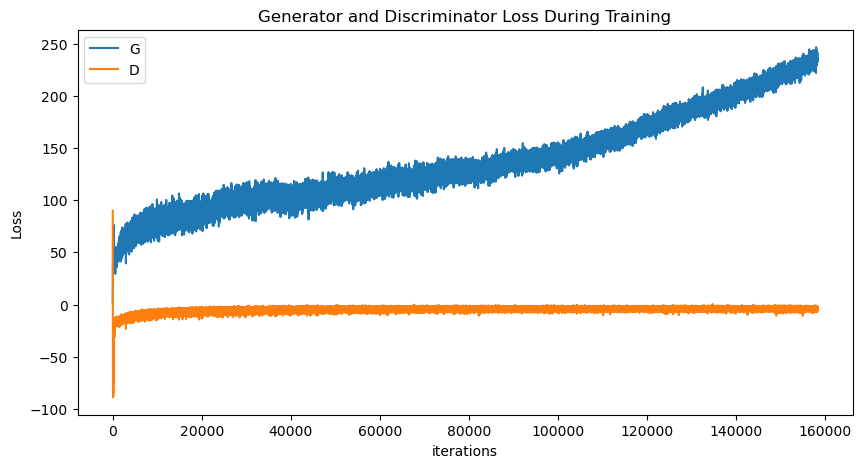

In [17]:
# Display losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
np.save('G_losses.npy',G_losses)
np.save('D_losses.npy',D_losses)